# Redes Neuronales - Trabajo Práctico N°1

## Ejercicio 1: Clasificador de texto

### 1. Introducción
<div style="text-align:justify; text-indent: 25px">
En este ejercicio se propuso entrenar un modelo que clasifique textos en 20 categorías, provistas por la librería "sklearn". Para importar los datos se usa la función "fetch_20newsgroups" con parámetros train y test, dependiendo del caso, como se puede ver en el siguiente bloque de código. 
</div>

<div style="text-align:justify; text-indent: 25px">
Los archivos "train_data.txt" y "test_data.txt" son los datos de "fetch_20newsgroups" ya lematizados con el WordNetLemmatizer del Natural Language Toolkit (nltk). Cada una de las líneas de cada uno de los archivos corresponde a la versión lematizada de cada uno de los textos, con lo cual se los puede separar con el método "splitLines" de la clase string.
</div>

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

twenty_train = fetch_20newsgroups(subset='train', shuffle=True, remove = ('headers', 'footers'))
targets_train = twenty_train['target']

twenty_test = fetch_20newsgroups(subset = 'test', remove = ('headers', 'footers'))
targets_test = twenty_test['target']

with open('Lemmatized/train_data.txt', 'rt') as file: train_data = file.read().splitlines()
with open('Lemmatized/test_data.txt', 'rt') as file: test_data = file.read().splitlines() 

### 2. Implementación
<div style="text-align:justify; text-indent: 25px">
Luego se define la clase "NewsClassifier", cuyo constructor recibe los parámetros que serán provistos al "TfidfVectorizer". Esta estructura se implementó para poder tener un modelo dinámico con hiperparámetros fácilmente modificables. Entre éstos se encontrarán: 
</div>

- $\textit{max_idf}$: Máxima frecuencia entre documentos permitida;
- $\textit{min_idf}$: Minima frecuencia entre documentos permitida;
- $\textit{sublinear_tf}$: Suavizado para grandes frecuencias de términos;
- $\textit{use_idf/smooth_idf}$: Uso de idf y suavizado para evitar divisiones por cero;
- $\textit{norm}$: Normalización (norma 1 o norma 2).

#### 2.1. Entrenamiento
<div style="text-align:justify; text-indent: 25px">
En primer lugar se le aplica la vertorización "TF-IDF" a los datos de entrenamiento, usando los parámetros pasados en el constructor. Esto nos dará una matriz esparza con puntajes: sus filas y columnas serán los textos y las palabras, respectivamente. Luego se guardan las probabilidades a priori de cada una de las clases. 
</div> 

<div style="text-align:justify; text-indent: 25px">
Paralelamente, se define una matriz de probabilidades de dimensión 20xN, donde "N" es la cantidad de palabras en el vocabulario, y se itera sobre cada una de las clases. En cada una de estas iteraciones, se suman los puntajes de cada una de las palabras en noticias de la clase por la cual se está iterando. A este resultado se le aplica un factor de $\textit{smoothing}$, con el propósito de evitar probabilidades iguales a cero. Finalmente, se divide a este vector de puntajes por la suma de todos sus componentes, para convertirlo en probabilidades. Este resultado final se guarda en la fila correspondiente de la matriz de probabilidades. Luego de iterar por todas las clases, el modelo queda entrenado y está apto para realizar predicciones.
</div>

#### 2.2. Predicción

<div style="text-align:justify; text-indent: 25px">
    Para predicir, primero se tomarán los textos a clasificar y se guardarán las repeticiones de cada palabra en cada noticia en en una matriz esparza. Cabe destacar que sólo serán tenidas en cuenta las palabras con las que el modelo fue entrenado. Con el proposito de utilizar "Naive Bayes", se quiere aplicar la siguiente fórmula:
</div>

<center>
    $P(x_1,x_2,...,x_N|y) = \prod_{i=1}^N P(x_i|y)^{n_{ij}}$
</center>


<div style="text-align:justify; text-indent: 25px">
    Donde $x_i$ es cada una de la palabras del vocabulario y $n_{ij}$ la cantidad de repeticiones de la palabra $x_i$ en el texto "j". Esta probabilidad obtenida será el likelihood naive, asumiendo independencia y approach BOW. Luego, se calcula este likelihood para cada una de las clases "y", y a cada una se la multiplica por su probabilidad a priori obtenida durante el entrenamiento. Finalmente se dirá que el texto pertenecerá a la clase con mayor probabilidad a posteriori, o sea, $P(y|x_1,x_2,...,x_N)$, que será proporcional a $P(x_1,x_2,...,x_N|y)\cdot P(y)$.
</div>

<div style="text-align:justify; text-indent: 25px">
El único cambio que en este trabajo se le aplicó a la fórmula de Naive Bayes fue el hecho de comparar los logaritmos de $P(y|x)$. Esto se decidió hacer así para evitar tener números muy pequeños debido a los productos de las probabilidades. Por lo tanto, la fórmula de Naive Bayes se reescribe de la siguiente forma:
</div>

<center>
    $\log(P(y|x)) = \log(P(y)) + \sum_{i=1}^N n_{ij}\cdot \log(P(x_i|y))$
</center>

<div style="text-align:justify; text-indent: 25px">
En la fórmula anterior se puede ver la necesidad del $\textit{smoothing}$ ya que, de no haberlo, se estarían evaluando logaritmos en cero.
</div>

<div style="text-align:justify; text-indent: 25px">
En el caso particular de este trabajo, con el fin de aplicar la fórmula mencionada, se tomará a la matriz de repeticiones provista por CountVectorizer, y se la multiplicará matricialmente por la matriz de logaritmos de probabilidades, traspuesta. Este producto matricial dará como resultado otra matriz, cuyas columnas serán las distintas clases y sus filas serán los distintos textos a clasificar. En los pares fila-columna $(i-j)$ estarán los logaritmos de likelihood del texto $i$ para la clase $j$. 
</div>

<div style="text-align:justify; text-indent: 25px">
Si a cada columna luego se le suma el logaritmo de la probabilidad a priori de la clase correspondiente, entonces la matriz se transformará en una matriz cuyos valores serán proporcionales a los logaritmos de las probabilidades a posteriori de cada noticia para cada clase. Finalmente, el vector de predicciones serán las columnas con probabilidad a posteriori máxima de cada fila.
</div>

In [3]:

class NewsClassifier:
    def __init__(self, **kwargs):
        self.tfidf = TfidfVectorizer(**kwargs, stop_words = 'english')

        self.got_hist = False
        self.fitted = False
        
    def fit(self, train_set, targets):
        
        self.got_hist = False
        
        self.train_set, self.targets_train = train_set, targets

        self.groups = np.unique(self.targets_train)
        
        self.fitted_train = self.tfidf.fit_transform(self.train_set)
        self.priori = np.mean(self.targets_train == self.groups.reshape(-1, 1), axis = 1)
        
        self.probabilities = np.zeros((20, self.fitted_train.shape[1]))
        
        for i, group in enumerate(self.groups):
            row = self.fitted_train[self.targets_train == group].sum(axis = 0)
            row += row[row > 0].min()
            self.probabilities[i] = row / row.sum()
        
        self.cv = CountVectorizer(stop_words = 'english', vocabulary = self.tfidf.get_feature_names())
        
        self.fitted = True
            
    def df_hist(self, **kwargs):
        if not self.got_hist:
            df = self.fitted_train.getnnz(axis = 0) / self.targets_train.size
        
            self.hist_height, self.hist_x, container = plt.hist(df * 100, bins = int(np.sqrt(df.size)), **kwargs)
            self.hist_width = (self.hist_x[-1] - self.hist_x[0]) / (self.hist_x.size - 1)
            self.hist_x = (self.hist_x[:-1] + self.hist_x[1:])/2
            self.got_hist = True
        else:
            plt.bar(self.hist_x, self.hist_height, width = self.hist_width)
        
        plt.yscale('log')
        plt.xlabel('%')
        if 'density' in kwargs and kwargs['density']: plt.ylabel('Density')
        else: plt.ylabel('Word count')
            
    def score(self, test_set, targets):
        return np.mean(self.predict(test_set) == targets)
    
    def check_fitted(self):
        if not self.fitted: raise Exception ('Cannot predict before fitting.')
    
    def predict(self, input_data):
        self.check_fitted()
        
        fitted_test = self.cv.transform(input_data)
        probs_test = fitted_test.dot(np.log(self.probabilities).T) + np.log(self.priori)
        
        return self.groups[np.argmax(probs_test, axis = 1)]

### 3. Análisis Exploratorio de Datos

<div style="text-align:justify; text-indent: 25px">
Para ver como se distribuyen las frecuencias entre documentos, se entrenó al modelo con los datos de entrenamiento, y se llamó a la función "df_hist". Ésta plotea un histograma de las frecuencias entre documentos. En la figura se puede ver que prácticamente no hay palabras que aparezcan en más del 50% de los documentos. Este dato se utilizará como referencia para elegir el hiperparámentro max_df. Además se puede ver que la gran mayoría de las palabras aparecen en un bajo porcentaje de los documentos. Este dato se utilizará para la elección del hiperparámetro min_df.
</div>

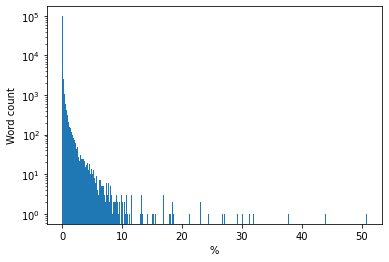

In [4]:
classifier = NewsClassifier(max_df = 1.0)                    
classifier.fit(train_data, targets_train)
classifier.df_hist(density = False)

### 4. Selección de hiperparámetros

#### 4.1 Validación
<div style="text-align:justify; text-indent: 25px">
Para la elección de los hiperparámetros se dividió a los datos de test en un grupo de validación y uno de testeo del modelo validado. Luego, se iteró por todas las combinaciones de hiperparámetros con el fin de encontrar la combinación que maximice la métrica utilizada en este ejercicio, que es el accuracy.    
</div>

In [14]:
max_df = np.arange(.01, .57, .05)
smooth_idf = np.array([True, False])
use_idf = np.array([True, False])
sublinear_tf = np.array([True, False])
norm = np.array(['l1', 'l2'])
validation, test, target_v, target_t = train_test_split(test_data, targets_test, test_size = 0.5, random_state = 0)

res = np.zeros((max_df.size, smooth_idf.size, use_idf.size, sublinear_tf.size, norm.size))

for i, df in enumerate(max_df):
    for j, smooth in enumerate(smooth_idf):
        for z, idf in enumerate(use_idf):
            for k, subtf in enumerate(sublinear_tf):
                for l, nrm in enumerate(norm):
                    classifier = NewsClassifier(max_df = df, smooth_idf = smooth, use_idf = idf, sublinear_tf = subtf, norm = nrm)
                    
                    classifier.fit(train_data, targets_train)
                    res[i, j, z, k, l] = classifier.score(validation, target_v)
                    
best = res.max()
argmax = np.argwhere(res == best)[-1]
print(f'Best max_df: {max_df[argmax[0]]}')
print(f'Best smoothing: {smooth_idf[argmax[1]]}')
print(f'Best use_idf: {use_idf[argmax[2]]}')
print(f'Best subtf: {sublinear_tf[argmax[3]]}')
print(f'Best norm: {norm[argmax[4]]}')
print(f'Best result: {best}')

Best max_df: 0.46
Best smoothing: False
Best use_idf: False
Best subtf: True
Best norm: l2
Best result: 0.7997875730217737


#### 4.2 Testeo
<div style="text-align:justify; text-indent: 25px">
Habiendo encontrado los hiperparámetros que mejor ajustaban a los datos de validación, se prosiguió a verificar dicho resultado con los datos de testeo, con el fin de evitar sesgo. Como se puede ver, el accuracy obtenido se sigue manteniendo con lo cual se considera que los hiperparámetros previamente encontrados son efectivos para ambas divisiones de dataset de test. 
</div>

In [10]:
classifier = NewsClassifier(max_df = max_df[argmax[0]], sublinear_tf = True, use_idf = False, norm = 'l2')
classifier.fit(train_data, targets_train)
print(classifier.score(test, target_t))

0.805894848645778


### 5. Resultado final
<div style="text-align:justify; text-indent: 25px">
Finalmente se procede a encontrar el accuracy con todo el dataset de test, que se espera que sea el promedio entre el accuracy de validación y el de testeo de hiperparámetros.
</div>

In [12]:
classifier = NewsClassifier(max_df = max_df[argmax[0]], sublinear_tf = True, use_idf = False)                    
classifier.fit(train_data, targets_train)
print(classifier.score(test_data, targets_test))

0.8028412108337759


<div style="text-align:justify; text-indent: 25px">
Como modelo alternativo, se lo puede comparar con el resultante de utilizar todos los datos ($\textit{max_df}\approx 0.55$). 
</div>

In [15]:
classifier = NewsClassifier(max_df = 0.55, sublinear_tf = True, use_idf = False)                    
classifier.fit(train_data, targets_train)
print(classifier.score(test_data, targets_test))

0.80323951141795


<div style="text-align:justify; text-indent: 25px">
Como se puede ver, los hiperparámetros presentaban un leve sesgo, ya que al utilizar todas las palabras el accuracy del dataset del test completo aumenta un 0.4%.
</div>

<div style="text-align:justify; text-indent: 25px">
Con este resultado, se puede concluir:
</div>

<center> $Accuracy = 80.32\%$ </center>